## Neutrino Diffractive Production of Vector Mesons

### Vector Meson Dominance 

The assumption of vector dominance in the context of charged-current neutrino-nucleon interaction is that the intermediate, virtual $W$-boson can be expressed as a sum of a bare $W$-boson state and a superposition of hadronic states that have the same quantum numbers as the original boson: 

$$|W\rangle = N\big(|W_B\rangle + \sum|h\rangle\big),$$

where $N$ is a normalization factor. Typically, we assume that only the lightest vector mesons contribute, such as $\rho^{\pm}$ or $a_1^{\pm}$. These hadronic states can be thought of as vacuum fluctuations of the $W$-boson into a quark-antiquark pair. This can only occur during a time interval allowed by the uncertainty principle: $\Delta t < 1/\Delta E$, where 

$$\Delta E = E_{\nu}-E_{\ell} -E_V$$
$$ = v - \sqrt{|\vec{q}|^2 + m_V^2}  = v-\sqrt{v^2+Q^2+m_V^2}$$
$$\sim \frac{Q^2+m_V^2}{2v} \; {\rm for}\;  v \gg \sqrt{Q^2+m_V^2}.$$

This means that the lifetime of the hadronic fluctutation scales as $\Delta t \sim 2v/(Q^2+m_V^2)$, under the assumption of small $Q^2$ and large transfer energy $v$. Thus, hadronic fluctuations are more likely when inelasticity is relatively large and Bjorken $x$ is small. 

The transition amplitude describing the process can be expressed as a product of the leptonic and hadronic currents from the weak interactions: 

$$\mathcal{M} = \frac{G_F}{\sqrt{2}}j_{\lambda}J^{\lambda},$$

where the leptonic current is $j_{\lambda} = \bar{\ell}\gamma_{\lambda}(1-\gamma_5)\nu_{\ell}$. We can write the hadronic current in terms of its vector and axial vector components: $J^{\lambda} = J_V^{\lambda}+J_A^{\lambda}$. The vector current is conserved by the CVC hypothesis. However, the axial vector is only "partially" conserved, which gives rise to the decay of the pion $\pi^+\rightarrow \mu^+\nu_{\mu}$. This is the case, because the amplitude for pion decay contains the matrix element $\langle 0| J^{\lambda}|\pi\rangle$, which, by Lorentz invariance, must scale with the pion four-momentum:

$$\langle 0| J^{\lambda}|\pi\rangle = if_{\pi}q^{\lambda},$$

where $f_{\pi}$ is the pion decay constant. Since the four-momentum $q^{\lambda}$ has odd parity, only the axial current can contribute to this matrix element, since the pion already has odd parity. Taking the divergence of the generalized matrix element, we obtain

$$\langle 0| \partial_{\lambda}J^{\lambda}(x)|\pi\rangle = \partial_{\lambda}\big(\langle 0| J_A^{\lambda}(0)|pi\ranglee^{-i q\cdot x}$$

We can separate the weak current into vector and axial vector components. 

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import interpolate
from scipy import integrate

import vegas
import functools
plt.style.use('/Users/barbaraskrzypek/Documents/IceCube/LVNeutrinos/LV/paper2.mplstyle')

In [2]:
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
N = 20
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(9/20, 1, N)
vals[:, 1] = np.linspace(.1, 1, N)
vals[:, 2] = np.linspace(.3, 1, N)
newcmp = ListedColormap(vals[::-1])

my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#745899-B999CE-FFFFFF-9FBFBD-007B7F
    (0.000, (0.455, 0.345, 0.600)),
    (0.250, (0.725, 0.600, 0.808)),
    (0.500, (1.000, 1.000, 1.000)),
    (0.750, (0.624, 0.749, 0.741)),
    (1.000, (0.000, 0.482, 0.498))))

my_gradient2 = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#FFFFFF-CCB1DE-B999CE-9672B8-6F5295
    (0.000, (1.000, 1.000, 1.000)),
    (0.250, (0.800, 0.694, 0.871)),
    (0.500, (0.725, 0.600, 0.808)),
    (0.750, (0.588, 0.447, 0.722)),
    (1.000, (0.435, 0.322, 0.584))))

#### Units

In [3]:
#units 

eV = 1
GeV = 1e9
MeV = 1e6 
keV = 1e3
gr = 5.62e32
meter = 5.06773093741e6
cm = 1e-2*meter
km = 1e5*cm
GF = 1.16639e-23
Na = 6.0221415e23
mb = 1e-27*cm**2

#### Constants

In [4]:
# constants 

sin2thetaW = 0.36
mrho = 775.28*MeV
Arho = 0.97401/np.sqrt(2)
Crho = 0.88e-38*cm**2/GeV**6
gsquared_rho = 1.25e-10/Crho*mb/GeV**6
sigmarho = 26*mb
mmu = 105*MeV

#### Transverse-Longitudinal Ratio

In [5]:
from scipy.optimize import curve_fit

def ratios(Q2,A,B):  #units of Q2 are in GeV^2

    return A*Q2/(B+Q2)**6

Q2_array = [1,3] #in GeV^2
ratio = [0.7,0.37] #from paper

fit_params = curve_fit(ratios,Q2_array,ratio)
A = fit_params[0][0]
B = fit_params[0][1]

def new_ratios(Q2,A,B):

    if Q2 > 3: ratio = 0.37
    
    else: ratio = ratios(Q2,A,B)

    return ratio 

ratios_vec = np.vectorize(lambda Q2,A,B: new_ratios(Q2,A,B)) #where units of Q2 are GeV^2

/Users/barbaraskrzypek/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


#### Differential Cross-Section

In [516]:
from scipy.special import expit

def diff_xs(E,t,y,Q2): 

    v = E*y

    factor = GF**2/(2*np.pi**2)
    propagator = Q2/(Q2+mrho**2)**2
    #epsilon = (1+(2*mrho**2/(4*E*mrho-Q2)))**(-1)
    epsilon = (4*E*(v)-Q2)/(2*v**2+Q2+4*E*(v))
    ratio = ratios_vec(Q2/(GeV**2),A,B)
    if Q2 > 3*GeV**2: 
        b = 6
    else: 
        b = 3.5
    coh_factor  = expit(b*t)
    #print(t)
    #print(coh_factor)
    xs = (1+epsilon*ratio)*sigmarho

    return factor*propagator*np.sqrt(v**2+Q2)*y/E/(1-epsilon)*(1/gsquared_rho)*coh_factor*xs

diff = np.vectorize(lambda Q2,y,t,E: diff_xs(E,t,y,Q2))


In [444]:
diff(1e-2*GeV**2,1e0*GeV**2,0.6,1e3*GeV)

array(5.05562713e-95)

#### Integration Limits

In [955]:
def tmin(Q,y,E):

    v = y*E

    return ((Q+mrho**2)/(2*v))**2

def q2Limits(y,t,E):

    return [0,4*E**2*(1-y)]

def yLimits(t,E):

    return [mrho**2/(2*E*np.sqrt(-1*t*GeV**2)),0.9]

def tLimits(E):

    return [-1e4,-1*(mrho**2/(2*E))**2/GeV**2]

def q2Range(y,t,E):

    q2max = np.log10(4*E**2*(1-y)*GeV**2)

    return np.logspace(-4,q2max,100)

def yrange(t,E):

    return np.linspace(mrho**2/(2*E*np.sqrt(-1*t*GeV**2)),0.99,100)

def trange(E):

    tmin = np.log10(1*(mrho**2/(2*E))**2/GeV**2)+2

    return np.logspace(tmin,6,100)

#def tLimits(Q,y,E):
#    return [-np.inf,-1*tmin(Q,y,E)/GeV**2]

#def q2Limits(y,E):
#    return [0,4*E**2*(1-y)]

#def yLimits(E):
#    return [mrho/(2*E),0.9]

In [967]:
mrho**2/(2*1e4*GeV*np.sqrt(1*1e-8*GeV**2))

0.3005295392

In [966]:
1*(mrho**2/(2*1e4*GeV))**2/GeV**2

9.031800393176434e-10

In [956]:
def diff_crossSection(E):

    return diff(q2Range(yrange(-1*trange(E),E),-1*trange(E),E),yrange(-1*trange(E),E),-1*trange(E),E)

In [857]:
np.shape(diff_crossSection(1e3*GeV))

/var/folders/_0/3wnhqpd14gv97z9b59dd3z480000gn/T/ipykernel_5519/3981520720.py:21: RuntimeWarning: divide by zero encountered in log10
  q2max = np.log10(4*E**2*(1-y)*GeV**2)


(100, 100, 100)

#### Integrating with simps

In [957]:
def q2Integral(E):

    integral = integrate.simps(diff_crossSection(E*GeV),q2Range(yrange(-1*trange(E),E),-1*trange(E),E),axis = 0)

    return integral

In [958]:
def Integral(E):

    integral = integrate.simps(integrate.simps(integrate.simps(diff_crossSection(E*GeV),q2Range(yrange(-1*trange(E),E),-1*trange(E),E),axis = 0),yrange(-1*trange(E),E),axis = 0),-1*trange(E),axis = 0)

    return integral

In [959]:
Integral(1e3*GeV)

-6.969309319771495e-68

In [913]:
energies = np.logspace(0,6,25)
integral = q2Integral(energies*GeV)

/var/folders/_0/3wnhqpd14gv97z9b59dd3z480000gn/T/ipykernel_5519/4266516509.py:21: RuntimeWarning: invalid value encountered in log10
  q2max = np.log10(4*E**2*(1-y)*GeV**2)
/var/folders/_0/3wnhqpd14gv97z9b59dd3z480000gn/T/ipykernel_5519/2402415151.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  return factor*propagator*np.sqrt(v**2+Q2)*y/E/(1-epsilon)*(1/gsquared_rho)*coh_factor*xs
/var/folders/_0/3wnhqpd14gv97z9b59dd3z480000gn/T/ipykernel_5519/2402415151.py:21: RuntimeWarning: invalid value encountered in scalar multiply
  return factor*propagator*np.sqrt(v**2+Q2)*y/E/(1-epsilon)*(1/gsquared_rho)*coh_factor*xs
/var/folders/_0/3wnhqpd14gv97z9b59dd3z480000gn/T/ipykernel_5519/4266516509.py:21: RuntimeWarning: divide by zero encountered in log10
  q2max = np.log10(4*E**2*(1-y)*GeV**2)
/Users/barbaraskrzypek/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:510: RuntimeWarning: invalid value encountered in add
  tmp = hsum/6.0 * (y[slice0] *


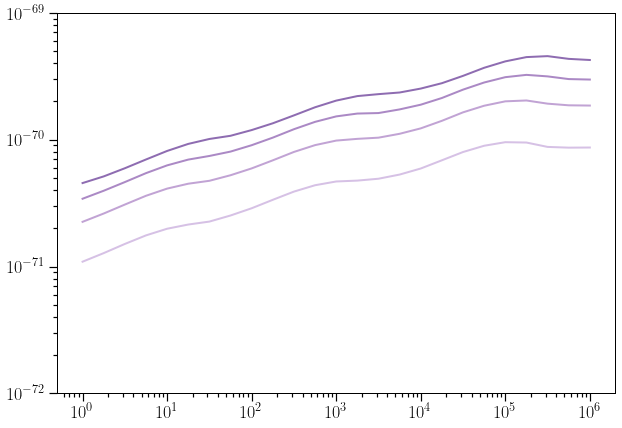

In [961]:
fig = plt.figure(figsize = (10,7))

tmin = (mrho**2/(2*E*GeV))/GeV**2

for i in range(4):

    plt.plot(energies,np.array(integral)[(i+1)*20,50,:],color = my_gradient2((i+1)/5))

plt.ylim(1e-72,1e-69)
#plt.xlim(1e-4,1e4)

plt.xscale('log')
plt.yscale('log')

plt.show()

#### $t$-integration

In [238]:
def tmin(Q,y,E):

    v = y*E

    return ((Q+mrho**2)/(2*v))**2

t_integral_vectorized2 = np.vectorize(lambda E,y,Q2: integrate.quad(diff,-1e2,-1*tmin(Q2,y,E)/GeV**2,args = (E,y,Q2,),limit = 1000)[0])

def t_integral(E,y,Q2): 

    integ = vegas.Integrator([[-1e2,-1*tmin(Q2,y,E)/GeV**2]])

    integral = integ(functools.partial(diff,E,y,Q2),nitn = 10,neval = 10000)[0].mean

    #integral = integrate.quad(diff,-1e2,-1*tmin(Q2,y,E)/GeV**2,args = (E,y,Q2,),epsabs=1.49e-20, epsrel=1.49e-20,limit = 10000)

    #print(integral[1])

    return integral

t_integral_vectorized = np.vectorize(lambda E,y,Q2: t_integral(E,y,Q2))

In [684]:
diff2 = np.vectorize(lambda t,Q2,y,E: diff(Q2,y,t,E))

def t_integral2(Q2,y,E):

    integ = integrate.quad(diff2,-np.inf,-1*tmin(Q2,y,E)/GeV**2,args = (Q2,y,E,),limit = 1000,epsabs = 1e-10,epsrel = 1e-10)

    return integ[0]

t_integral2_vectorized = np.vectorize(lambda E,y,Q2: t_integral2(Q2,y,E))

In [685]:
t_integral2_vectorized(1e3*GeV,0.6,1e-2*GeV**2)/mb**2

4.129446588736735e-50

In [686]:
def gallard_calculaltion(E,y,Q2): 

    v = E*y

    factor = GF**2/(2*np.pi**2)/E
    mass = mrho
    coupling = gsquared_rho
    propagator = Q2/(1+Q2/(mass**2))**2
    epsilon = (4*E*(E-v)-Q2)/(2*v**2+Q2+4*E*(E-v))
    ratio = ratios_vec(Q2/(GeV**2),A,B)
    if Q2 > 3*GeV**2: 
        b = 6/(GeV**2)
    else: 
        b = 3.5/(GeV**2)
    coh_factor  = np.exp(-1*b*(tmin(Q2,y,E)-tmin(0,y,E))) 
    xs = (1+epsilon*ratio)*sigmarho

    return factor*(1/coupling)*propagator*np.sqrt(v**2+Q2)/(1-epsilon)*coh_factor*xs

gallard_calculaltion_vectorized = np.vectorize(gallard_calculaltion)

In [700]:
energies = np.logspace(1,6,6)
y = 1e-4
y2 = 0.9

pdfs = []
pdfs2 = []

for e in energies: 

    q2_array = np.logspace(-16,6,100)
    x_array = q2_array/(2*e*y)

    integral = t_integral2_vectorized(e*GeV,y,q2_array*GeV**2)
    integral2 = t_integral2_vectorized(e*GeV,y2,q2_array*GeV**2)
    #gallard_integral = gallard_calculaltion_vectorized(e*GeV,y,q2_array*GeV**2)

    pdfs.append(integral)
    pdfs2.append(integral2)

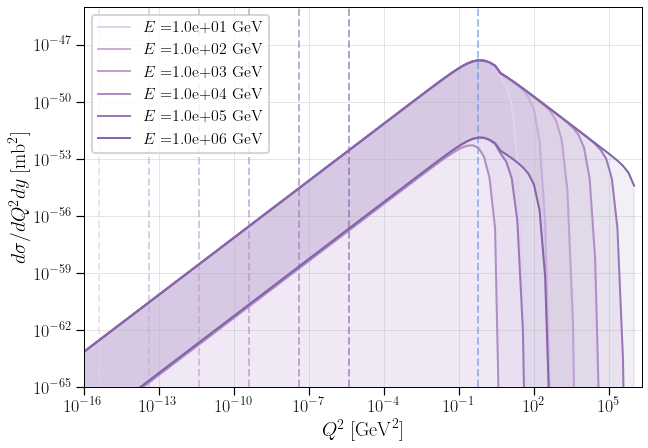

In [706]:
fig = plt.figure(figsize = (10,7))

plt.axvline(mrho**2/GeV**2,color = "cornflowerblue",ls = "dashed",alpha = 0.6)

qmax = 4*energies**2*(1-y)

for ei in range(len(energies)):

    plt.axvline(qmax[ei]/GeV**2,color = my_gradient2((ei+1)/7),ls = "dashed",alpha = 0.6)

    plt.fill_between(q2_array,np.array(pdfs)[ei]/mb**2,np.array(pdfs2)[ei]/mb**2,color = my_gradient2((ei+1)/7),alpha = 0.1)

    #plt.plot(q2_array,np.array(pdfs)[ei]/mb**2,color = my_gradient2((ei+1)/7),label = r"$E = ${:.1e}".format(energies[ei])+" GeV")
    plt.plot(q2_array,np.array(pdfs)[ei]/mb**2,color = my_gradient2((ei+1)/7),label = r"$E = ${:.1e}".format(energies[ei])+" GeV")
    plt.plot(q2_array,np.array(pdfs2)[ei]/mb**2,color = my_gradient2((ei+1)/7))

plt.grid(alpha = 0.4)
plt.legend(loc = "upper left",fontsize = 16,ncol = 1,frameon = True)

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$d\sigma/dQ^2dy\; [{\rm mb}^2]$",fontsize = 20)
plt.xlabel(r"$Q^2\;[{\rm GeV}^2]$",fontsize = 20)
#plt.xlabel(r"$x$",fontsize = 20)
plt.xlim(1e-16,2e6)
plt.ylim(1e-65,1e-45)

plt.savefig("/Users/barbaraskrzypek/Documents/IceCube/LVNeutrinos/tIntegral.png",dpi = 400,bbox_inches = "tight")
plt.show()

#### $Q^2$-Integration

In [636]:
def q2_integral(E,y,t):

    integral = integrate.quad(diff,0,4*E**2*(1-y),args = (y,t,E,),limit = 1000,epsabs = 1e-50,epsrel = 1e-50)

    return integral[0]

q2_integral_vectorized = np.vectorize(lambda E,y,t: q2_integral(E,y,t))

In [637]:
q2_integral_vectorized(1e3*GeV,0.6,-1e-2)

array(2.37214021e-64)

In [638]:
energies = np.logspace(0,6,50)

pmin = q2_integral_vectorized(energies*GeV,1e-6,-1*t)/mb**2
pmax = q2_integral_vectorized(energies*GeV,0.9,-1*t)/mb**2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


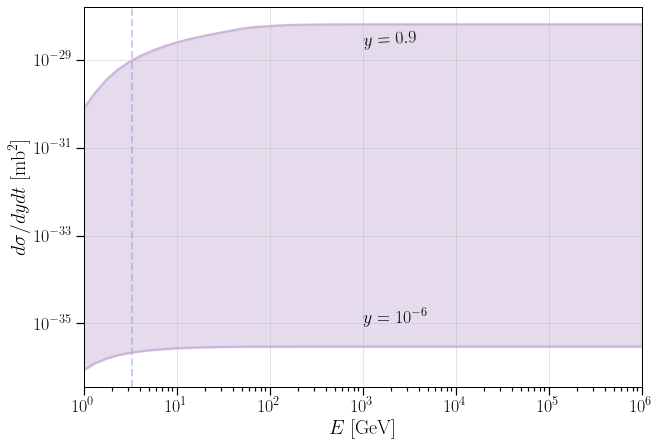

In [639]:
fig = plt.figure(figsize = (10,7))

t = 1e-2

i = 0

energies = np.logspace(0,6,50)

plt.axvline(mrho**2/(2*np.sqrt(t*GeV**2)*0.9)/GeV,color = "cornflowerblue",ls = "dashed",alpha = 0.4)

plt.plot(energies,pmin,color = my_gradient(0.3),alpha = 0.8)
plt.plot(energies,pmax,color = my_gradient(0.3),alpha = 0.8)
plt.fill_between(energies,pmin,pmax,color = my_gradient2(0.4),alpha = 0.4)

plt.text(1e3,2e-29,r"$y = 0.9$",rotation = 4)
plt.text(1e3,1e-35,r"$y = 10^{-6}$",rotation = 0)

plt.grid(alpha = 0.4)
plt.legend(loc = "lower left",fontsize = 14,ncol = 2)

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e0,1e6)
plt.xlabel(r"$E\;[\rm GeV]$",fontsize = 20)
plt.ylabel(r"$d\sigma/dydt\; [{\rm mb}^2]$",fontsize = 20)

plt.savefig("/Users/barbaraskrzypek/Documents/IceCube/LVNeutrinos/q2Integral.png",dpi = 400,bbox_inches = "tight")
plt.show()

In [664]:
y_array = np.linspace(0,1,100)
t = 1e-2

xsmin = q2_integral_vectorized(1e0*GeV,y_array,-1*t)
xsmax = q2_integral_vectorized(1e6*GeV,y_array,-1*t)

xsmin2 = q2_integral_vectorized(1e0*GeV,y_array,-1*1e-6)
xsmax2 = q2_integral_vectorized(1e6*GeV,y_array,-1*1e-6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


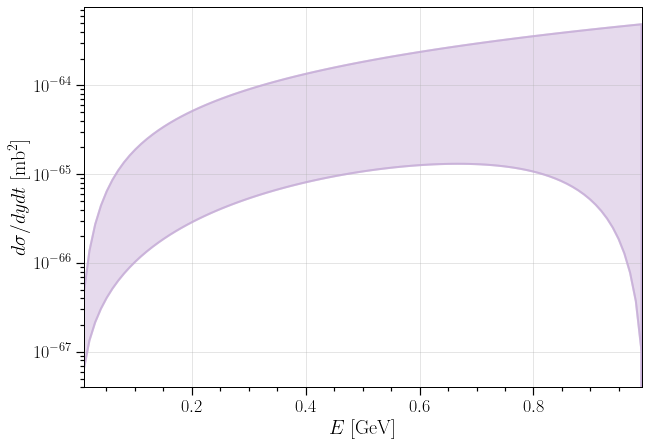

In [666]:
fig = plt.figure(figsize = (10,7))

t = 1e-2

i = 0

plt.axvline(mrho**2/(2*np.sqrt(t*GeV**2)*1e6*GeV),color = "cornflowerblue",ls = "dashed",alpha = 0.4)

plt.plot(y_array,xsmin,color = my_gradient(0.3),alpha = 0.8)
plt.plot(y_array,xsmax,color = my_gradient(0.3),alpha = 0.8)
plt.fill_between(y_array,xsmin,xsmax,color = my_gradient2(0.4),alpha = 0.4)

plt.grid(alpha = 0.4)
plt.legend(loc = "lower left",fontsize = 14,ncol = 2)

#plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,0.99)
plt.xlabel(r"$E\;[\rm GeV]$",fontsize = 20)
plt.ylabel(r"$d\sigma/dydt\; [{\rm mb}^2]$",fontsize = 20)

plt.savefig("/Users/barbaraskrzypek/Documents/IceCube/LVNeutrinos/q2Integral.png",dpi = 400,bbox_inches = "tight")
plt.show()

#### Using nquad

In [846]:
def ops0(E,t,y): 

    return {"epsabs":1e-50,"epsrel":1e-50,"limit":10000}

def ops1(E,t):

    return {"epsabs":1e-100,"epsrel":1e-100,"limit":10000}

def ops2(E):

    return {}

def cross_section(E,t): 

    integral = integrate.nquad(diff,[q2Limits,yLimits],args = (t,E,),opts = [ops0,ops1])

    return integral

cross_section2 = np.vectorize(lambda E,t: cross_section(E,t))


In [847]:
print(mrho**2/(2*1e3*GeV*np.sqrt(1e-2*GeV**2)))

0.003005295392


In [848]:
cross_section2(1e3*GeV,-1e-2)

(array(1.57372421e-64), array(4.80428221e-64))

In [803]:
energies = np.logspace(1,6,6)
t_array = -1*np.logspace(-4,3,100)

pdfs = []

for e in energies: 

    p = cross_section2(e*GeV,t_array)/cm**2
    pdfs.append(p)

/Users/barbaraskrzypek/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


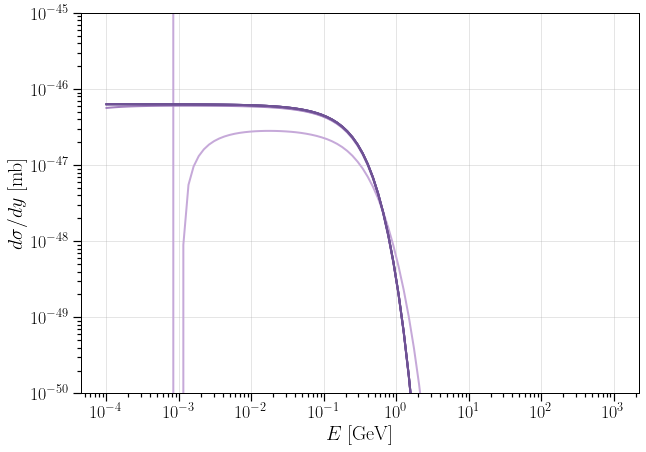

In [804]:
fig = plt.figure(figsize = (10,7))

ymin = (mrho**2/(2*energies*GeV))**2

for yi in range(len(energies)):

    #plt.axvline(ymin[yi]/GeV**2,color = "cornflowerblue",ls = "dashed",alpha = 0.6)

    plt.plot(-1*t_array[::-1],np.array(pdfs)[yi][::-1]*cm**2/mb,color = my_gradient2((yi+1)/3))

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-50,1e-45)
#plt.xlim(1e1,1e6)
#plt.xlim(2e-4,1e2)

plt.grid(alpha = 0.4)

plt.ylabel(r"$d\sigma/dy\; [\rm mb]$",fontsize = 20)
plt.xlabel(r"$E\;[\rm GeV]$",fontsize = 20)

plt.show()

#### $y$-Integration

In [80]:
def y_integral(E):

    integral = integrate.quad(q2_integral_vectorized,mrho/(2*E*GeV),0.9,args = (E,),epsabs=1.49e-10, epsrel=1.49e-10,limit = 1000)

    return integral[0]

y_integral_vectorized = np.vectorize(lambda E: y_integral(E))

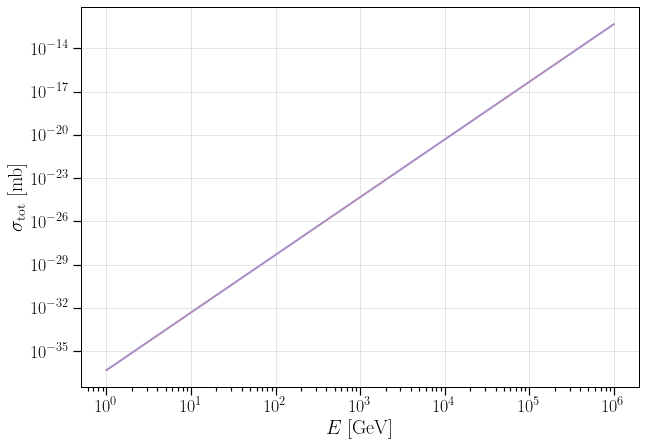

In [87]:
fig = plt.figure(figsize = (10,7))

plt.plot(energies,-1*y_integral_vectorized(energies*GeV)/mb,color = my_gradient(0.2))

plt.grid(alpha = 0.4)

plt.xlabel(r"$E \; [\rm GeV]$",fontsize = 20)
plt.ylabel(r"$\sigma_{\rm tot} \; [\rm mb]$",fontsize = 20)

plt.xscale('log')
plt.yscale('log')

plt.savefig("/Users/barbaraskrzypek/Documents/IceCube/LVNeutrinos/sigma.png",dpi = 400,bbox_inches = "tight")
plt.show()

In [788]:
def ops0(E,t,y): 

    return {"epsabs":1e-50,"epsrel":1e-50,"limit":100}

def ops1(E,t):

    return {"epsabs":1e-50,"epsrel":1e-50,"limit":100}

def ops2(E):

    return {"epsabs":1e-25,"epsrel":1e-25,"limit":100}

def cross_section(E): 

    integral = integrate.nquad(diff,[q2Limits,yLimits,tLimits],args = (E,),opts = [ops0,ops1,ops2])

    return integral

cross_section2 = np.vectorize(lambda E: cross_section(E))

In [791]:
cross_section2(1e0*GeV)

(array(9.11477048e-81), array(1.8122947e-80))

In [767]:
energies = np.logspace(2,6,100)

p = cross_section2(energies*GeV**2)

array([1.46016785e-74, 1.46016785e-74, 1.46016785e-74, 1.46016785e-74,
       1.46016785e-74, 1.46016785e-74, 1.46016785e-74, 1.46016785e-74,
       1.46016785e-74, 1.46016785e-74, 1.46016785e-74, 1.46016785e-74,
       1.46016785e-74, 1.46016785e-74, 1.46016785e-74, 1.46016785e-74,
       1.46016785e-74, 1.46016785e-74, 1.46016785e-74, 1.46016785e-74,
       1.46016785e-74, 1.46016785e-74, 1.46016785e-74, 1.46016785e-74,
       1.46016785e-74, 1.46016785e-74, 1.46016785e-74, 1.46016785e-74,
       1.46016785e-74, 1.46016785e-74, 1.46016785e-74, 1.46016785e-74,
       1.46016785e-74, 1.46016785e-74, 1.46016785e-74, 1.46016785e-74,
       1.46016785e-74, 1.46016785e-74, 1.46016785e-74, 1.46016785e-74,
       1.46016785e-74, 1.46016785e-74, 1.46016785e-74, 1.46016785e-74,
       1.46016785e-74, 1.46016785e-74, 1.46016785e-74, 1.46016785e-74,
       1.46016785e-74, 1.46016785e-74, 1.46016785e-74, 1.46016785e-74,
       1.46016785e-74, 1.46016785e-74, 1.46016785e-74, 1.46016785e-74,
      